In [1]:
import sys
sys.path.append('../build/Debug/')
from transformations import (quaternion_matrix as quaternion_to_matrix,
                             euler_matrix as euler_to_matrix, 
                             euler_from_quaternion)
from plot import *

import librigid_body_motion_estimation as rigid_body_motion_estimation
%pylab inline
np.set_printoptions(suppress=True)

Populating the interactive namespace from numpy and matplotlib


# Rigid Body Motion Estimation

This notebook presents rigid body motion estimation using geometric algebra. We presents method in both the Euclidean and the conformal model. In the Euclidean model the rigid body transformations are modelled as a rotor and a translation vector and in the conformal model as motors.

The motor estimation in the conformal model presents novel results by estimating the motor through its bivector generator. This is similar to the approaches used in quaternion estimation in 3D.

## Estimating rigid body transformations in the Euclidean model

Consider the 3-dimensional Euclidean space, $\mathbb{E}^3$, with basis $\{ e_1, e_2, e_3 \}$. The corresponding geometric algebra $\mathbb{G}_3$ is of dimension 8 with basis

$$ \{ 1, e_1, e_2, e_3, e_{12}, e_{13}, e_{23}, e_{123} \}.$$

The Euclidean rotors form a subalgebra of $\mathbb{G}_3$ with basis $\{ 1, e_{12}, e_{13}, e_{23}  \}$. Rotors are isomorphic to Quaternions, $\mathbb{H}$.

Given two corresponding, and possibly noisy, point sets the optimal rotor that transform one point set onto the other is found by minimizing the cost function 

$$ E = \frac{1}{2} \| b - R a \tilde{R} + t  \|^2 $$

## Generate data sets

In [2]:
# Generate rotation matrix
r = euler_to_matrix(0.0,0.0,-np.pi/3.0)[:3,:3]
r

array([[ 0.5      ,  0.8660254,  0.       ],
       [-0.8660254,  0.5      , -0.       ],
       [-0.       ,  0.       ,  1.       ]])

In [3]:
# translation vector
t = np.array([0.1, 2.0, 3.0])
t

array([ 0.1,  2. ,  3. ])

In [4]:
# Generate initial point sets
n_points = 10
points_a = np.random.rand(n_points,3)
points_b = np.array([np.dot(r,point.reshape(3,1)).reshape(3) + t for point in points_a])
# Add noise to the rotated point cloud
sigma = 0.1
mu = 0.0
points_b_noisy = points_b + sigma * np.random.randn(n_points,3) + mu

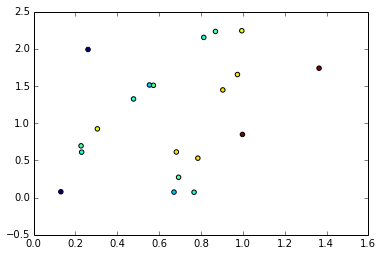

In [5]:
plot_xy_projection(points_a, points_b_noisy)

In [6]:
rtbe = rigid_body_motion_estimation.RotorTranslationVectorBivectorGeneratorEstimation()
b0 = np.array([0.2, 0.0, 0.0]).reshape(3,1)
t00 = np.array([-100.0, 0.0, 0.0]).reshape(3,1)
rt1 = rtbe.run(b0, t00, points_a, points_b_noisy)
rtbe.summary()['brief_report']

'Ceres Solver Report: Iterations: 7, Initial cost: 5.051089e+04, Final cost: 7.039310e-02, Termination: CONVERGENCE'

In [7]:
rte = rigid_body_motion_estimation.RotorTranslationVectorEstimation()
r0 = np.array([1.0, 0.0, 0.0, 0.0]).reshape(4,1)
t01 = np.array([-100.0, 0.0, 0.0]).reshape(3,1)
rt2 = rte.run(r0, t01, points_a, points_b_noisy)
rte.summary()['brief_report']

'Ceres Solver Report: Iterations: 7, Initial cost: 5.028441e+04, Final cost: 7.039310e-02, Termination: CONVERGENCE'

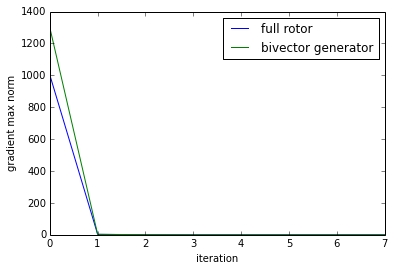

In [8]:
iterations_rtbe = rtbe.summary()['iterations']
iterations_rte = rte.summary()['iterations']
plt.plot([iteration['gradient_max_norm'] for iteration in iterations_rte], label='full rotor')
plt.plot([iteration['gradient_max_norm'] for iteration in iterations_rtbe], label='bivector generator')
plt.legend()
plt.xticks([iteration['iteration'] for iteration in max(iterations_rte, iterations_rtbe)])
plt.xlabel('iteration')
plt.ylabel('gradient max norm')
plt.show()

In [9]:
rt1

array([[ 0.86355388],
       [ 0.50183464],
       [-0.04544883],
       [-0.0192635 ],
       [ 0.12668607],
       [ 2.02018552],
       [ 2.92847996]])

In [10]:
rt2

array([[ 0.8635539 ],
       [ 0.50183461],
       [-0.04544897],
       [-0.01926352],
       [ 0.12668614],
       [ 2.02018544],
       [ 2.92847976]])

In [37]:
gre = rigid_body_motion_estimation.GeneralRotorEstimation()
r02 = np.array([1.0, 0.0, 0.0, 0.0]).reshape(4,1)
t02 = np.array([0.1, 0.0, 0.0]).reshape(3,1)
gre_rt = gre.run(r02, t02, points_a, points_b_noisy)
gre.summary()['brief_report']

'Ceres Solver Report: Iterations: 10, Initial cost: 5.473893e+01, Final cost: 5.473893e+01, Termination: CONVERGENCE'

In [38]:
points_a

array([[ 0.22676829,  0.69592691,  0.46004271],
       [ 0.68205824,  0.61330599,  0.23226575],
       [ 0.76689549,  0.07230001,  0.54473702],
       [ 0.69287319,  0.2731462 ,  0.42329788],
       [ 0.13024668,  0.07855514,  0.72786078],
       [ 0.30489623,  0.92395259,  0.04926286],
       [ 0.99812474,  0.84892356,  0.00683685],
       [ 0.67093352,  0.07411038,  0.13157638],
       [ 0.78500055,  0.53016356,  0.10483718],
       [ 0.22970933,  0.61072909,  0.05013109]])

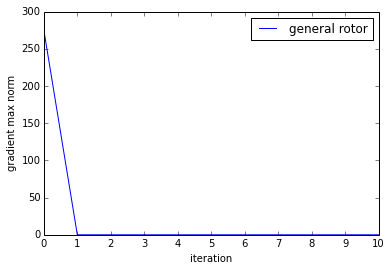

In [41]:
iterations = gre.summary()['iterations']
plt.plot([iteration['gradient_max_norm'] for iteration in iterations], label='general rotor')
plt.legend()
plt.xticks([iteration['iteration'] for iteration in iterations])
plt.xlabel('iteration')
plt.ylabel('gradient max norm')
plt.show()